In [2]:
# Path setup
import sys
import os

sys.path.append("/home/dchen/Random_Forest_Weights/")

# Basics:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Helpful:
from sklearn.model_selection import train_test_split

# Pipeline and ColumnsTransformer:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# models:
import statsmodels.api as sm

# my functions:
from src_rf.methods.calc_mean import *
from src_rf.methods.calc_weights import *
from src_rf.methods.calc_dist import *
from src_rf.datasets.qrf_2.load_weights_qrf_2 import * 
from src_rf.methods.filter_weights_rf import * 

### 0. Setup

In [3]:
dir_path = "/Data/Delong_BA_Data/rf_weights/qrf_2/"

### 1. Load Data, Modify and Split

In [4]:
df = pd.read_csv("/home/dchen/Random_Forest_Weights/src_rf/data/energy_data_hourly.csv"
                 , index_col = 'datetime', parse_dates=True)

df.drop(['residual_energy_usage', 'pump_storage'], inplace = True, axis =  1)
# Extract the year from the index
df['Year'] = df.index.year

year_dummies = pd.get_dummies(df['Year'], prefix='Year')
month_dummies = pd.get_dummies(df['month'], prefix='Month')
hour_dummies = pd.get_dummies(df['hour'], prefix='Hour')

# Drop the original columns and join with dummy variables
df = df.drop(['Year', 'month', 'hour'], axis=1)
df = df.join([year_dummies, month_dummies, hour_dummies])

df['Count'] = range(0, df.shape[0])

In [5]:
X = df.drop('total_energy_usage', axis = 1)
y = df['total_energy_usage']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3 ,shuffle=False, random_state=42)

### 2. Load qrf_2 weights

In [6]:
qrf_2_weights = load_weights_qrf_2(dir_path)

### 3. Weight Exploration

#### 3.1 Test Date to look at

In [35]:
test_date = 10
print(X_test.iloc[test_date, 0:][X_test.iloc[test_date, 0:] != 0])

Friday           1
Year_2020        1
Month_6          1
Hour_2           1
Count        47738
Name: 2020-06-12 02:00:00, dtype: int64


#### 3.2 Load Weights

In [30]:
qrf_2_weight_0 = filter_weight_rf(qrf_2_weights , test_date)
qrf_2_weight_0.sum()

0.9999999999999994

#### 3.3 Non-Zero Values

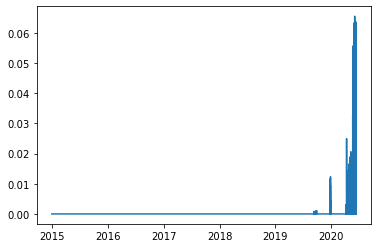

In [31]:
plt.plot(X_train.index, qrf_2_weight_0)
plt.show()

In [32]:
non_zeros =  np.where(qrf_2_weight_0 != 0)[0]

In [33]:
print('Year:')
print(X_train.iloc[non_zeros, :].index.year.value_counts().sort_values(ascending = False))
print(100 * '-')

print('Month:')
print(X_train.iloc[non_zeros, :].index.month.value_counts().sort_values(ascending = False))
print(100 * '-')

print('Week day:')
# Here, weekday gives a number where 0 is Monday and 6 is Sunday. We then map these numbers to their string names.
print(X_train.iloc[non_zeros, :].index.weekday.map({0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'})
      .value_counts().sort_values(ascending = False))
print(100 * '-')

print('Hour:')
print(X_train.iloc[non_zeros, :].index.hour.value_counts().sort_values(ascending = False))

Year:
2020    39
2019    12
Name: datetime, dtype: int64
----------------------------------------------------------------------------------------------------
Month:
5     17
4     15
9      7
6      7
12     5
Name: datetime, dtype: int64
----------------------------------------------------------------------------------------------------
Week day:
Tuesday      14
Wednesday    13
Thursday     12
Friday       12
Name: datetime, dtype: int64
----------------------------------------------------------------------------------------------------
Hour:
2    51
Name: datetime, dtype: int64
